In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv
import pandas as pd
import scipy.optimize as sp
import time

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

%run ./aux_funcs.py
%run ./RSRG_class.py
%run ./aux_funcs.py

In [4]:
log_file = pd.read_csv("output/pre_09_03_23/log_file.csv")
ts_list = log_file['ts'].tolist()
log_file

,L,steps,a,b,w,n_runs,ts
0,100,9500,0.1,0.105,3.5,240,1677292884
1,100,9500,0.1,0.105,3.7,240,1677301472
2,100,9500,0.1,0.105,3.9,240,1677311242
3,100,9500,0.1,0.105,4.1,240,1677321801
4,100,9500,0.1,0.105,4.3,240,1677333387
...,...,...,...,...,...,...,...
64,90,8035,0.1,0.105,2.6,240,1678180453
65,90,8035,0.1,0.105,2.8,240,1678182512
66,90,8035,0.1,0.105,3.0,240,1678185218
67,90,8035,0.1,0.105,3.2,240,1678188576


In [28]:
def generate_corr_matrix(reverse_dict, L):
    vect = np.zeros(shape=(L*L, L*L), dtype=bool)
    for key in reverse_dict:
        if reverse_dict[key] is None: continue
        vect[key,reverse_dict[key]] = True
    return np.einsum('ab,ac->bc', vect, vect)

def generate_corr_matrix_alt(clust_dict, L):
    corr_mat_alt = np.zeros(shape=(L*L, L*L), dtype=bool)
    for i in range(L*L):
        for j in range(i, L*L):
            corr_mat_alt[i,j] = (clust_dict[i]==clust_dict[j])
    corr_mat_alt = corr_mat_alt.T + corr_mat_alt 
    return corr_mat_alt

def generate_corr_matrix_alt2(clust_dict, reverse_dict, L):
    #Fastest
    corr_mat = np.zeros(shape=(L*L, L*L), dtype=bool)
    for i in range(L*L):
        corr_mat[i, reverse_dict[clust_dict[i]]] = True
    return corr_mat

def power_law(x, scale, power):
    return scale*x**(-power)

In [23]:
L = 90


fixed_length_slice = log_file[lambda df: (df['L'] == L)]
ts_list = fixed_length_slice['ts'].tolist()
w_vals = fixed_length_slice['w'].tolist()
n_runs_list = fixed_length_slice['n_runs'].tolist()

mean_corr_mat_list = []

for index, ts in enumerate(ts_list):
    
    
    with open("output/pre_09_03_23/Ising_2D_cmat_"+str(ts)+".pkl", "rb") as fp:   
        c_mat = pickle.load(fp)
        
    mean_corr_mat_list.append(c_mat)
    

0.40535605297704697 0.7420748588001804
0.5460537972153783 1.1790828114447702
0.8065154544905617 1.613087353489214
0.6652474724747418 1.7586865914615726


<ipython-input-28-eb63381508fd>:24: RuntimeWarning: divide by zero encountered in power
  return scale*x**(-power)


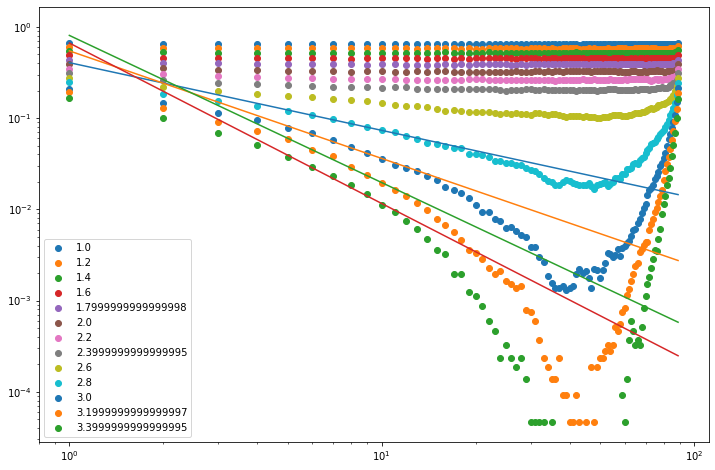

In [29]:
plt.figure(figsize=(12, 8))

for index, w in enumerate(w_vals):
    if not index%1==0: continue
    mean_corr_mat = mean_corr_mat_list[index]
    y_vals = np.arange(L)
    corr_function = np.zeros(shape=(L))

    for y in range(L):
        for x in range(L):
            corr_function[y] += mean_corr_mat[index_map(0,x,L), index_map(y,x,L)]

    plt.scatter(y_vals, corr_function/L, label=str(w))
    
    if index>8:
        
        popt, pcov = curve_fit(power_law, y_vals[5:15],corr_function[5:15]/L)

        print(*popt)
        plt.plot(y_vals, power_law(y_vals, *popt))

plt.legend()
plt.xscale('log')
plt.yscale('log')
#plt.xlim(0, 20)
#print(*popt)

In [11]:
ts = 1681168497

with open("IsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)


clust_dict_list, reverse_dict_list = [], []

for core_pair in clust_list_final:
    clust_list_temp = core_pair[0]
    reverse_list_temp = core_pair[1]
    clust_dict_list+=clust_list_temp
    reverse_dict_list+=reverse_list_temp

t0 = time.time()
corr_mat_alt2 = generate_corr_matrix_alt2(clust_dict_list[0], reverse_dict_list[0], 50)
print(time.time()-t0)

0.08069372177124023
